## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2

from keras.applications.vgg19 import VGG19

Using plaidml.keras.backend backend.


In [3]:
dataset_path = "../../LEGO_brick_custom/"
dataset_output = "./output"

In [4]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input #required to format input

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=[1,1.2],
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=[0.6,1],
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), color_mode="rgb", target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), color_mode="rgb", target_size=(200,200), shuffle=True, class_mode='categorical')

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anto\anaconda3\envs\lego_

In [6]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(200,200,3))

#freeze layers for first time training
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(1024)(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(512)(top_model)
top_model = Dense(len(train_generator.class_indices), activation="softmax")(top_model)

model = Model(inputs = base_model.inputs, outputs = top_model)

model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling

In [7]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="model/model_vertical.png", show_shapes = True)
plot_model(model, to_file="model/model_horizontal.png", show_shapes = True)

In [8]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau
from datetime import datetime

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=16,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=4,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

#https://keras.io/guides/writing_your_own_callbacks/
class timeCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        _time = datetime.now()
        print(_time.strftime("%H:%M:%S"))

callbacks = [checkpoint, tensorboard, csvlogger, reduceLR, earlystop, timeCallback()]

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [9]:
from keras.optimizers import Adam

opt = Adam(lr=1e-3)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)


#first train normally with vgg16 layers locked
history = model.fit_generator(
    train_generator, 
    validation_data  = validation_generator,
    epochs = 100, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/100
840/840 [==============================] - 923s 1s/step - loss: 7.7208 - acc: 0.4503 - val_loss: 3.9510 - val_acc: 0.5730

Epoch 00001: val_loss improved from inf to 3.95101, saving model to ./base.model
18:04:05
Epoch 2/100
840/840 [==============================] - 886s 1s/step - loss: 3.1677 - acc: 0.5930 - val_loss: 1.7324 - val_acc: 0.6066

Epoch 00002: val_loss improved from 3.95101 to 1.73245, saving model to ./base.model
18:18:52
Epoch 3/100
840/840 [==============================] - 887s 1s/step - loss: 1.7034 - acc: 0.6331 - val_loss: 1.1132 - val_acc: 0.7196

Epoch 00003: val_loss improved from 1.73245 to 1.11320, saving model to ./base.model
18:33:41
Epoch 4/100
840/840 [==============================] - 886s 1s/step - loss: 1.8445 - acc: 0.6118 - val_loss: 2.6961 - val_acc: 0.5248

Epoch 00004: val_loss did not improve from 1.11320
18:48:27
Epoch 5/100
840/840 [==============================] - 890s 1s/step - loss: 2.1675 - acc: 0.6027 - val_loss: 2.4144 - val_

In [10]:
json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

In [18]:
import matplotlib.pyplot as plt

def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

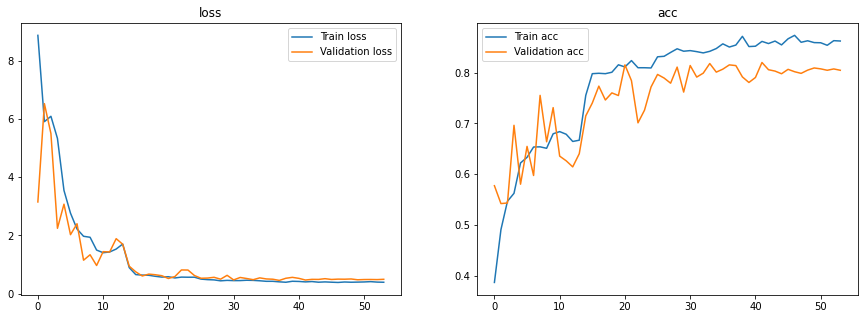

In [19]:
show_final_history(history)

In [21]:
#fine tune by unlocking training for only last conv block and using a low learning rate
for layer in base_model.layers[:-4]:
    layer.trainable = True

opt = Adam(lr=1e-6)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

#train again
history = model.fit_generator(
    train_generator, 
    steps_per_epoch  = 300, 
    validation_data  = validation_generator,
    validation_steps = 100,
    epochs = 10, 
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

Epoch 1/10
300/300 [==============================] - 1044s 3s/step - loss: 0.4009 - acc: 0.8580 - val_loss: 0.5693 - val_acc: 0.7697

Epoch 00001: val_loss did not improve from 0.45153
20:37:29
Epoch 2/10
300/300 [==============================] - 970s 3s/step - loss: 0.3669 - acc: 0.8749 - val_loss: 0.4821 - val_acc: 0.8097

Epoch 00002: val_loss did not improve from 0.45153
20:53:39
Epoch 3/10
300/300 [==============================] - 1004s 3s/step - loss: 0.3662 - acc: 0.8704 - val_loss: 0.4226 - val_acc: 0.8306

Epoch 00003: val_loss improved from 0.45153 to 0.42256, saving model to ./base.model
21:10:25
Epoch 4/10
300/300 [==============================] - 934s 3s/step - loss: 0.3636 - acc: 0.8741 - val_loss: 0.4556 - val_acc: 0.8213

Epoch 00004: val_loss did not improve from 0.42256
21:25:59
Epoch 5/10
300/300 [==============================] - 922s 3s/step - loss: 0.3461 - acc: 0.8776 - val_loss: 0.4415 - val_acc: 0.8216

Epoch 00005: val_loss did not improve from 0.42256
21:

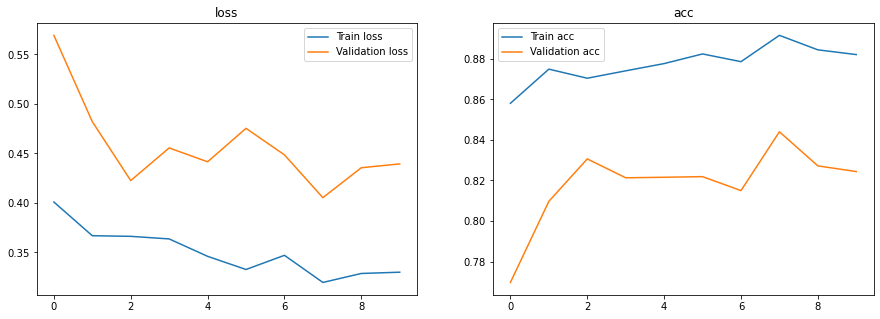

In [22]:
show_final_history(history)

We can try and test the model on random new images

In [25]:
import cv2
from keras.applications.vgg16 import preprocess_input #required to format input

image_path = "../../LEGO_brick_custom/3298 roof tile 2x3/3298_6_20.png"
image = cv2.imread(image_path)

from numpy import array
json_file = open("./model/lego.json", "r")
json_model = json_file.read()
json_file.close()

loaded_model = keras.models.model_from_json(json_model)
loaded_model.load_weights("./model/lego_weights.h5")

loaded_model.summary()
image = np.expand_dims(image, axis=0)
image = preprocess_input(image) #before testing we have to convert the image

prediction = loaded_model.predict(image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [26]:
print(prediction[0])
print(prediction[0].tolist().index(max(prediction[0])))
print(list(validation_generator.class_indices.keys())[prediction[0].tolist().index(max(prediction[0]))])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 6.0771525e-28 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
16
3298 roof tile 2x3
